# Simon Task fMRI – First-level GLM Analysis

#### This notebook performs:
#### 1. Behavioral data inspection (number of trials, congruency, subjects).
#### 2. First-level GLM analysis for 21 subjects using Nilearn.
#### 3. Saving Z-maps for the contrast: incongruent > congruent.

In [1]:
# Import libraries
import os
import glob
import numpy as np
import pandas as pd

from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

In [2]:
# Configuration

# Base directory containing the BIDS-format dataset
base_path = "data/ds101_R2.0.0/"

# Repetition Time (TR) of the fMRI acquisition, in seconds
TR = 2.0
#The dataset contains two runs per subject
runs = [1, 2]

print("Todo cargó bien")

Todo cargó bien


In [3]:
# Path to behavioral files inside the BIDS dataset
events_files = sorted(glob.glob(os.path.join(base_path, "sub-*", "func", "*_events.tsv")))

all_events = []

# Load all behavioral files and concatenate them
for f in events_files:
    df = pd.read_csv(f, sep="\t")
    subject = f.split("sub-")[1].split("/")[0]   # extract subject ID
    df["subject"] = subject
    all_events.append(df)

# Combine all subjects into one DataFrame
behaviour = pd.concat(all_events, ignore_index=True)

# Visualization

print("Shape of the behavioral dataset:", behaviour.shape)

print("\nTrials per congruency:")
print(behaviour["trial_type"].value_counts())

print("\nTrials per subject:")
print(behaviour["subject"].value_counts())

# Display first rows for inspection
behaviour.head()

Shape of the behavioral dataset: (4067, 10)

Trials per congruency:
trial_type
congruent_correct        1979
incongruent_correct      1936
incongruent_incorrect      90
congruent_incorrect        62
Name: count, dtype: int64

Trials per subject:
subject
17    195
16    195
14    195
12    195
01    194
09    194
15    194
13    194
21    194
08    194
07    194
06    194
05    194
03    194
04    193
18    193
11    193
10    192
02    192
19    192
20    192
Name: count, dtype: int64


,onset,duration,trial_type,correctness,StimVar,behav_unlabeled,Rsponse,Stimulus,cond,subject
0,0.0,0.0,congruent_incorrect,incorrect,incongruent,0,2,692,cond002,01
1,0.0,1.0,incongruent_incorrect,incorrect,incongruent,0,2,692,cond004,01
2,2.5,1.0,incongruent_correct,correct,incongruent,1,2,624,cond003,01
3,5.0,1.0,congruent_correct,correct,congruent,1,1,1477,cond001,01
4,7.5,1.0,congruent_correct,correct,congruent,1,1,578,cond001,01


In [4]:
# Create an output directory to store the resulting Z maps
output_dir = "first_level_results"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Function recode trial types
def map_congruency(tt):
    """
    Maps the original trial_type strings to either
    "congruent" or "incongruent" based on keyword matching.
    Any other type is discarded (returns None).
    """
    tt = str(tt).lower()
    if "incongruent" in tt:
        return "incongruent"
    elif "congruent" in tt:
        return "congruent"
    else:
        return None

In [6]:
# List of subjects: sub-01 through sub-21
subjects = [f"sub-{i:02d}" for i in range(1, 22)]
for s in subjects:
    print(s)

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-17
sub-18
sub-19
sub-20
sub-21


In [7]:
# Behavioral master DataFrame clean

# This cell:
#  - Reads all *_events.tsv files for all subjects
#  - Extracts subject, run, trial number
#  - Splits trial_type into congruency + accuracy
#  - Creates binary label (0 = congruent, 1 = incongruent)
#  - Selects only relevant behavioral variables
#  - Saves a clean CSV version of the dataset

import glob
import pandas as pd

# Pattern to find all event files for all subjects
pattern = os.path.join(base_path, "sub-*", "func", "*_events.tsv")
files = sorted(glob.glob(pattern))

print("Number of event files found:", len(files))

all_rows = []

for f in files:
    # Read events file
    df = pd.read_csv(f, sep="\t")
    
    # Extract subject and run from file path
    subject = f.split("/")[-3]      # e.g., "sub-01"
    run = f.split("/")[-1]          # full file name of the run
    
    df["subject"] = subject
    df["run"] = run
    
    # Continuous trial number within each run
    df["trial"] = range(1, len(df) + 1)
    
    # Extract congruency and accuracy from trial_type
    # Example format: "congruent_correct"
    df["congruency"] = df["trial_type"].str.split("_").str[0]
    df["accuracy_label"] = df["trial_type"].str.split("_").str[1]

    # Binary label used for ML:
    # 0 = congruent, 1 = incongruent
    df["label"] = df["congruency"].map({"congruent": 0, "incongruent": 1})

    # Keep only relevant columns
    df_clean = df[[
        "subject",
        "run",
        "trial",
        "trial_type",
        "congruency",
        "accuracy_label",
        "correctness",
        "StimVar",
        "behav_unlabeled",
        "Rsponse",
        "Stimulus",
        "cond",
        "label"
    ]]
    
    all_rows.append(df_clean)

# Combine the cleaned datasets
behaviour = pd.concat(all_rows, ignore_index=True)

# Show first rows
behaviour.head(20)

# Save clean CSV
output_csv_path = "simon_behaviour_clean.csv"
behaviour.to_csv(output_csv_path, index=False)

print("\nSaved clean behavioral dataset to:", output_csv_path)
print("\nDataFrame shape:", behaviour.shape)

print("\nTrials per congruency:")
print(behaviour["congruency"].value_counts())

print("\nTrials per subject:")
print(behaviour["subject"].value_counts())

Number of event files found: 42

Saved clean behavioral dataset to: simon_behaviour_clean.csv

DataFrame shape: (4067, 13)

Trials per congruency:
congruency
congruent      2041
incongruent    2026
Name: count, dtype: int64

Trials per subject:
subject
sub-17    195
sub-16    195
sub-14    195
sub-12    195
sub-01    194
sub-09    194
sub-15    194
sub-13    194
sub-21    194
sub-08    194
sub-07    194
sub-06    194
sub-05    194
sub-03    194
sub-04    193
sub-18    193
sub-11    193
sub-10    192
sub-02    192
sub-19    192
sub-20    192
Name: count, dtype: int64


In [8]:
# Make sure the subjects list is correct
subjects = [f"sub-{i:02d}" for i in range(1, 22)]
print("Subjects that will be processed:", subjects)

Subjects that will be processed: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21']


In [9]:
# MAIN LOOP OVER SUBJECTS
print("Subjects to be processed:", subjects)

for subject in subjects:
    print("\n==============================")
    print("Processing:", subject)
    print("yeaaaahhh")

    # Lists to store fMRI images and design matrices across the two runs
    fmri_imgs = []
    design_matrices = []

    # Loop through both runs
    for run in runs:
        # Load preprocessed fMRI BOLD image
        fmri_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_bold.nii.gz"
        )
        img = image.load_img(fmri_file)
        fmri_imgs.append(img)

        # Determine number of volumes (scans) in the run
        n_scans = img.shape[-1]

        # Define frame times in seconds using the TR
        frame_times = np.arange(n_scans) * TR

        # Load and recode events file
        events_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_events.tsv"
        )
        events = pd.read_csv(events_file, sep="\t")

        # Apply congruency recoding
        events["trial_type"] = events["trial_type"].apply(map_congruency)

        # Remove trials that are not congruent or incongruent
        events = events[events["trial_type"].notna()]

        # Build design matrix for this run
        design = make_first_level_design_matrix(
            frame_times=frame_times,
            events=events,
            hrf_model="glover",     # Hemodynamic Response Function model
            drift_model="cosine",   # Drift model for low-frequency noise
            high_pass=0.01          # High-pass filter cutoff (Hz)
        )
        design_matrices.append(design)

Subjects to be processed: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21']

Processing: sub-01
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-02
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-03
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-04
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-05
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-06
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-07
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-08
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-09
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-10
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-11
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-12
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-13
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-14
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-15
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-16
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


Processing: sub-17
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-18
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-19
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-20
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(



Processing: sub-21
yeaaaahhh


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


In [10]:
# FIRST-LEVEL GLM FOR ALL SUBJECTS

output_dir = "first_level_results"
os.makedirs(output_dir, exist_ok=True)

print("Output directory:", os.path.abspath(output_dir))

for subject in subjects:
    print("\n==============================")
    print("Processing:", subject)
    print("==============================")

    fmri_imgs = []
    design_matrices = []

    for run in runs:
        # Load preprocessed fMRI BOLD image
        fmri_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_bold.nii.gz"
        )
        print("  fMRI file:", fmri_file)
        img = image.load_img(fmri_file)
        fmri_imgs.append(img)

        # Frame times
        n_scans = img.shape[-1]
        frame_times = np.arange(n_scans) * TR

        # Load events
        events_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_events.tsv"
        )
        print("  Events file:", events_file)
        events = pd.read_csv(events_file, sep="\t")

        # Recode trial_type
        events["trial_type"] = events["trial_type"].apply(map_congruency)
        events = events[events["trial_type"].notna()]

        # Design matrix
        design = make_first_level_design_matrix(
            frame_times=frame_times,
            events=events,
            hrf_model="glover",
            drift_model="cosine",
            high_pass=0.01
        )
        design_matrices.append(design)

    # Fit GLM
    glm = FirstLevelModel(
        t_r=TR,
        smoothing_fwhm=5.0,
        minimize_memory=True
    ).fit(
        fmri_imgs,
        design_matrices=design_matrices
    )

    # Contrast
    z_map = glm.compute_contrast(
        "incongruent - congruent",
        output_type="z_score"
    )

    # Save Z-map
    out_path = os.path.join(
        output_dir,
        f"{subject}_zmap_incongruent_vs_congruent.nii.gz"
    )
    z_map.to_filename(out_path)
    print(f"  Z map saved at: {out_path}")

Output directory: /Users/antoniaolgui/Desktop/simon-ml-project/first_level_results

Processing: sub-01
  fMRI file: data/ds101_R2.0.0/sub-01/func/sub-01_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-01/func/sub-01_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-01/func/sub-01_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-01/func/sub-01_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-01_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-02
  fMRI file: data/ds101_R2.0.0/sub-02/func/sub-02_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-02/func/sub-02_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-02/func/sub-02_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-02/func/sub-02_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-02_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-03
  fMRI file: data/ds101_R2.0.0/sub-03/func/sub-03_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-03/func/sub-03_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-03/func/sub-03_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-03/func/sub-03_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-03_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-04
  fMRI file: data/ds101_R2.0.0/sub-04/func/sub-04_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-04/func/sub-04_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-04/func/sub-04_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-04/func/sub-04_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-04_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-05
  fMRI file: data/ds101_R2.0.0/sub-05/func/sub-05_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-05/func/sub-05_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-05/func/sub-05_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-05/func/sub-05_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-05_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-06
  fMRI file: data/ds101_R2.0.0/sub-06/func/sub-06_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-06/func/sub-06_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-06/func/sub-06_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-06/func/sub-06_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-06_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-07
  fMRI file: data/ds101_R2.0.0/sub-07/func/sub-07_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-07/func/sub-07_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-07/func/sub-07_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-07/func/sub-07_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-07_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-08
  fMRI file: data/ds101_R2.0.0/sub-08/func/sub-08_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-08/func/sub-08_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-08/func/sub-08_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-08/func/sub-08_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-08_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-09
  fMRI file: data/ds101_R2.0.0/sub-09/func/sub-09_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-09/func/sub-09_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-09/func/sub-09_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-09/func/sub-09_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-09_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-10
  fMRI file: data/ds101_R2.0.0/sub-10/func/sub-10_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-10/func/sub-10_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-10/func/sub-10_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-10/func/sub-10_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-10_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-11
  fMRI file: data/ds101_R2.0.0/sub-11/func/sub-11_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-11/func/sub-11_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-11/func/sub-11_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-11/func/sub-11_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-11_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-12
  fMRI file: data/ds101_R2.0.0/sub-12/func/sub-12_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-12/func/sub-12_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-12/func/sub-12_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-12/func/sub-12_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-12_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-13
  fMRI file: data/ds101_R2.0.0/sub-13/func/sub-13_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-13/func/sub-13_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-13/func/sub-13_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-13/func/sub-13_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-13_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-14
  fMRI file: data/ds101_R2.0.0/sub-14/func/sub-14_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-14/func/sub-14_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-14/func/sub-14_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-14/func/sub-14_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-14_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-15
  fMRI file: data/ds101_R2.0.0/sub-15/func/sub-15_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-15/func/sub-15_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-15/func/sub-15_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-15/func/sub-15_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-15_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-16
  fMRI file: data/ds101_R2.0.0/sub-16/func/sub-16_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-16/func/sub-16_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-16/func/sub-16_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-16/func/sub-16_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-16_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-17
  fMRI file: data/ds101_R2.0.0/sub-17/func/sub-17_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-17/func/sub-17_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-17/func/sub-17_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent, incongruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-17/func/sub-17_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-17_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-18
  fMRI file: data/ds101_R2.0.0/sub-18/func/sub-18_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-18/func/sub-18_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-18/func/sub-18_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-18/func/sub-18_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-18_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-19
  fMRI file: data/ds101_R2.0.0/sub-19/func/sub-19_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-19/func/sub-19_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-19/func/sub-19_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-19/func/sub-19_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-19_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-20
  fMRI file: data/ds101_R2.0.0/sub-20/func/sub-20_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-20/func/sub-20_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-20/func/sub-20_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-20/func/sub-20_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(
/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


  Z map saved at: first_level_results/sub-20_zmap_incongruent_vs_congruent.nii.gz

Processing: sub-21
  fMRI file: data/ds101_R2.0.0/sub-21/func/sub-21_task-simon_run-1_bold.nii.gz
  Events file: data/ds101_R2.0.0/sub-21/func/sub-21_task-simon_run-1_events.tsv
  fMRI file: data/ds101_R2.0.0/sub-21/func/sub-21_task-simon_run-2_bold.nii.gz


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Events file: data/ds101_R2.0.0/sub-21/func/sub-21_task-simon_run-2_events.tsv


/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
congruent.
  warnings.warn(
/opt/anaconda3/envs/signalanalysis/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: behav_unlabeled, Rsponse, correctness, cond, StimVar, Stimulus
  warnings.warn(


  Z map saved at: first_level_results/sub-21_zmap_incongruent_vs_congruent.nii.gz


/var/folders/tm/j1qm4zkn2wzdp9yz49zq7xr80000gn/T/ipykernel_63247/871017624.py:67: UserWarning: One contrast given, assuming it for all 2 runs
  z_map = glm.compute_contrast(


In [12]:
print("Files in first_level_results:")
for f in sorted(os.listdir("first_level_results")):
    print(f)

Files in first_level_results:
.DS_Store
sub-01_zmap_incongruent_vs_congruent.nii.gz
sub-02_zmap_incongruent_vs_congruent.nii.gz
sub-03_zmap_incongruent_vs_congruent.nii.gz
sub-04_zmap_incongruent_vs_congruent.nii.gz
sub-05_zmap_incongruent_vs_congruent.nii.gz
sub-06_zmap_incongruent_vs_congruent.nii.gz
sub-07_zmap_incongruent_vs_congruent.nii.gz
sub-08_zmap_incongruent_vs_congruent.nii.gz
sub-09_zmap_incongruent_vs_congruent.nii.gz
sub-10_zmap_incongruent_vs_congruent.nii.gz
sub-11_zmap_incongruent_vs_congruent.nii.gz
sub-12_zmap_incongruent_vs_congruent.nii.gz
sub-13_zmap_incongruent_vs_congruent.nii.gz
sub-14_zmap_incongruent_vs_congruent.nii.gz
sub-15_zmap_incongruent_vs_congruent.nii.gz
sub-16_zmap_incongruent_vs_congruent.nii.gz
sub-17_zmap_incongruent_vs_congruent.nii.gz
sub-18_zmap_incongruent_vs_congruent.nii.gz
sub-19_zmap_incongruent_vs_congruent.nii.gz
sub-20_zmap_incongruent_vs_congruent.nii.gz
sub-21_zmap_incongruent_vs_congruent.nii.gz


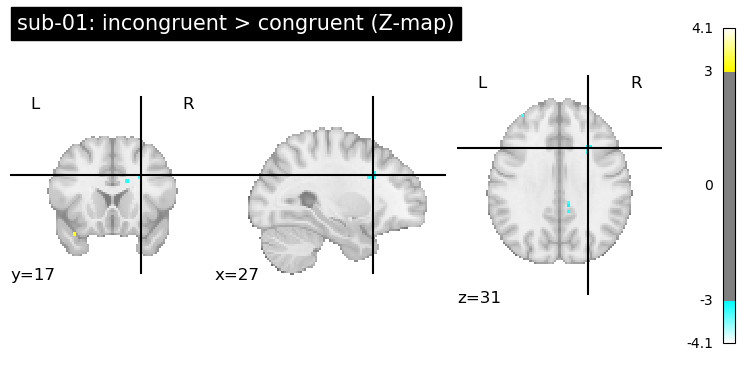

In [13]:
# Visualize one example Z-MAP
example_subject = "sub-01"

example_file = os.path.join(
    output_dir,
    f"{example_subject}_zmap_incongruent_vs_congruent.nii.gz"
)

z_map_example = image.load_img(example_file)

plotting.plot_stat_map(
    z_map_example,
    title=f"{example_subject}: incongruent > congruent (Z-map)",
    threshold=3.0
)
plotting.show()

Z-map shape: (64, 64, 40)
Central slice index (z-axis): 20


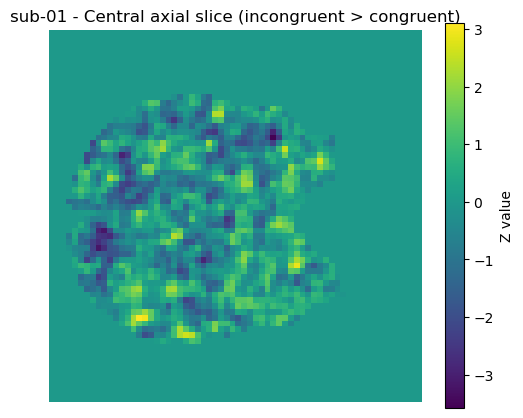

In [14]:
# Visualize central axial slice as 2D Matrix

import matplotlib.pyplot as plt
import numpy as np
from nilearn import image

# Choose one example subject
example_subject = "sub-01"

# Path to the subject's Z-map
example_file = os.path.join(
    output_dir,
    f"{example_subject}_zmap_incongruent_vs_congruent.nii.gz"
)

# Load the Z-map image
z_map_example = image.load_img(example_file)

# Get the 3D data array (x, y, z)
data = z_map_example.get_fdata()

# Compute the index of the central axial slice
# Axis 2 corresponds to the z-dimension (axial)
slice_idx = data.shape[2] // 2

# Extract the central axial slice
central_slice = data[:, :, slice_idx]

print("Z-map shape:", data.shape)
print("Central slice index (z-axis):", slice_idx)

# Plot the slice as a 2D matrix
plt.figure(figsize=(6, 5))
plt.imshow(central_slice, origin="lower")
plt.colorbar(label="Z value")
plt.title(f"{example_subject} - Central axial slice (incongruent > congruent)")
plt.axis("off")
plt.show()

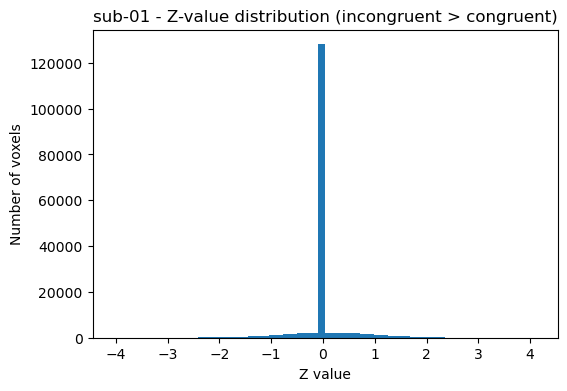

In [15]:
# Histogram of Z values

# Flatten the 3D array into 1D
z_values = data.flatten()

# Keep only finite values (avoid NaNs or infs)
z_values = z_values[np.isfinite(z_values)]

plt.figure(figsize=(6, 4))
plt.hist(z_values, bins=60)
plt.xlabel("Z value")
plt.ylabel("Number of voxels")
plt.title(f"{example_subject} - Z-value distribution (incongruent > congruent)")
plt.show()